In [59]:
import cv2 as cv
from os import listdir
import preprocess_lego_image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
data_dir_labeled = '..\\data\\labeled'
labels = listdir(data_dir_labeled)
labels

['15712tile1x1withopenoclip', '3023plate1x2', '43857liftarmthick1x2']

In [11]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
def load_data():
    data = []
    for label in labels:
        label_path = f'{data_dir_labeled}\\{label}'
        image_paths = listdir(label_path)
        for image_path in image_paths:                
            image = preprocess_lego_image.preprocess(f'{label_path}\\{image_path}')
            data.append([label, image])
    return data

labeled_data = load_data()

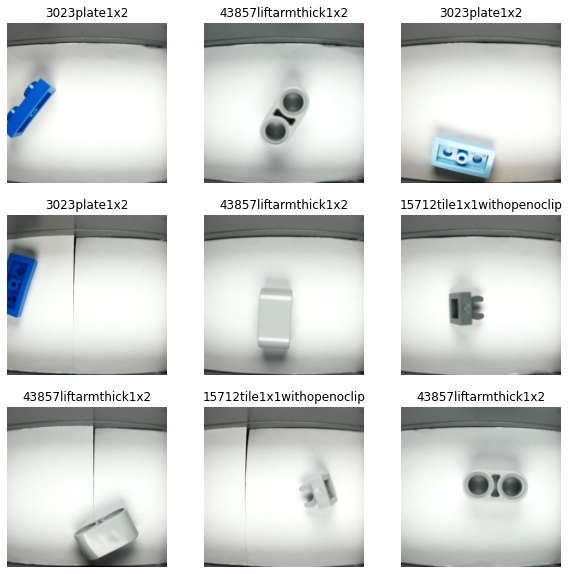

In [14]:
plt.figure(figsize=(10, 10))
i = 0
for label, image in random.sample(labeled_data, 9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis("off")
    i = i + 1

In [21]:
df = pd.DataFrame(labeled_data,columns = ['label','image'])
data_train = df.sample(frac=0.8, random_state=1)
data_test = df.drop(data_train.index)
print(f'# training data: {len(data_train)}')
print(f'# training data: {len(data_test)}')

# training data: 25
# training data: 6


In [139]:
label_tensor = tf.convert_to_tensor(list(set(labels)))
label_tensor

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'15712tile1x1withopenoclip', b'43857liftarmthick1x2',
       b'3023plate1x2'], dtype=object)>

In [49]:
label_tensor == '43857liftarmthick1x2'

<tf.Tensor: shape=(3,), dtype=bool, numpy=array([False,  True, False])>

In [79]:
X_train = np.array(data_train.drop(['label'], axis=1))
y_train = np.array(data_train['label'].apply(lambda l: tf.argmax(l == label_tensor)))
X_test = np.array(data_test.drop(['label'], axis=1))
y_test = np.array(data_test['label'].apply(lambda l: tf.argmax(l == label_tensor)))

In [110]:
L = []
for k in X_train:
    L += [k[0]]
L = np.array(L)
X_train = L
X_train.shape

(25, 256, 256, 3)

In [111]:
P = []
for k in X_test:
    P += [k[0]]
P = np.array(P)
X_test = P
X_test.shape

(6, 256, 256, 3)

In [113]:
X_test[0].shape

(256, 256, 3)

In [116]:
from keras.applications.vgg16 import VGG16, preprocess_input
X_test = preprocess_input(X_test)
X_train = preprocess_input(X_train)
X_test.shape

(6, 256, 256, 3)

In [127]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [122]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
vgg16.trainable = False

In [140]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_tensor)))

In [141]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total params: 31,558,467
Trainable params: 16,843,779
Non-trainable params: 14,714,688
_________________________________________________________________


In [142]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [143]:
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=1)

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 26.0079 - accuracy: 0.3200 - val_loss: 7289.2422 - val_accuracy: 0.3333
Epoch 2/20
1/1 [==============================] - 0s 60ms/step - loss: 9114.9492 - accuracy: 0.3600 - val_loss: 48.4378 - val_accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 0s 59ms/step - loss: 116.7967 - accuracy: 0.4800 - val_loss: 283.0669 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 58ms/step - loss: 331.1404 - accuracy: 0.4000 - val_loss: 181.3380 - val_accuracy: 0.1667
Epoch 5/20
1/1 [==============================] - 0s 57ms/step - loss: 222.1934 - accuracy: 0.4800 - val_loss: 43.5502 - val_accuracy: 0.1667
Epoch 6/20
1/1 [==============================] - 0s 57ms/step - loss: 72.9320 - accuracy: 0.4800 - val_loss: 26.2584 - val_accuracy: 0.3333
Epoch 7/20
1/1 [==============================] - 0s 60ms/step - loss: 28.2615 - accuracy: 0.2400 - val_loss: 81.4429 - val_accuracy: 0.5000
Epoch 

In [144]:
expected_label, example_image = random.sample(labeled_data, 1)[0]
expected_label

'3023plate1x2'

In [146]:
prediction = model.predict(preprocess_input(np.array([example_image])))

In [147]:
np.argmax(prediction)

2

In [149]:
label_tensor[np.argmax(prediction)].numpy()

b'3023plate1x2'